In [ ]:
!pip install numpy
!pip install deepxde
!pip install tensorflow
!pip install mpl_toolkits.mplot3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement mpl_toolkits.mplot3d (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.mplot3d


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!cp /content/your_notebook.ipynb /content/drive/MyDrive/


MessageError: Error: credential propagation was unsuccessful

In [5]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dde.config.set_default_float("float64")


# Geometry of the problem
L, W, H = 1.0, 1.0, 6.0  # Length, width, height of the cuboid
geom = dde.geometry.Cuboid(xmin=[0, 0, 0], xmax=[L, W, H])

# Material parameters for the Mooney-Rivlin model
C1 = 1.0  # MPa, first model parameter
C2 = 0.1  # MPa, second model parameter

#_______________________________________________________________________________

# PDE eqs with normalization:

def pde(inputs, outputs):
    # Normalized coordinates
    x_norm, y_norm, z_norm = inputs[:, 0:1], inputs[:, 1:2], inputs[:, 2:3]

    # Decompose the outputs into displacement components
    u = outputs[:, 0:1]
    v = outputs[:, 1:2]
    w = outputs[:, 2:3]

    # Calculate the gradients (strains) adjusted by the scales
    u_x = dde.grad.jacobian(u, inputs, j=0) / L  # du/dx_original = (du/dx_norm) / L
    u_y = dde.grad.jacobian(u, inputs, j=1) / W  # du/dy_original = (du/dy_norm) / W
    u_z = dde.grad.jacobian(u, inputs, j=2) / H  # du/dz_original = (du/dz_norm) / H

    v_x = dde.grad.jacobian(v, inputs, j=0) / L
    v_y = dde.grad.jacobian(v, inputs, j=1) / W
    v_z = dde.grad.jacobian(v, inputs, j=2) / H

    w_x = dde.grad.jacobian(w, inputs, j=0) / L
    w_y = dde.grad.jacobian(w, inputs, j=1) / W
    w_z = dde.grad.jacobian(w, inputs, j=2) / H

    # Green-Lagrange strain tensor 
    E_xx = u_x
    E_yy = v_y
    E_zz = w_z
    E_xy = 0.5 * (u_y + v_x)
    E_xz = 0.5 * (u_z + w_x)
    E_yz = 0.5 * (v_z + w_y)

    # Strain invariants
    I1 = E_xx + E_yy + E_zz
    I2 = E_xx * E_yy + E_yy * E_zz + E_zz * E_xx - E_xy**2 - E_xz**2 - E_yz**2

    # Stress tensors (Mooney-Rivlin model)
    S_xx = 2 * C1 + 2 * C2 * (I1 - 3)
    S_yy = 2 * C1 + 2 * C2 * (I1 - 3)
    S_zz = 2 * C1 + 2 * C2 * (I1 - 3)
    S_xy = 2 * C2 * E_xy
    S_xz = 2 * C2 * E_xz
    S_yz = 2 * C2 * E_yz

    # Divergence of the stress tensor adjusted by the scales
    div_S_x = (dde.grad.jacobian(S_xx, inputs, j=0) / L +
               dde.grad.jacobian(S_xy, inputs, j=1) / W +
               dde.grad.jacobian(S_xz, inputs, j=2) / H)

    div_S_y = (dde.grad.jacobian(S_xy, inputs, j=0) / L +
               dde.grad.jacobian(S_yy, inputs, j=1) / W +
               dde.grad.jacobian(S_yz, inputs, j=2) / H)

    div_S_z = (dde.grad.jacobian(S_xz, inputs, j=0) / L +
               dde.grad.jacobian(S_yz, inputs, j=1) / W +
               dde.grad.jacobian(S_zz, inputs, j=2) / H)

    # Equilibrium equations
    f_x = div_S_x
    f_y = div_S_y
    f_z = div_S_z

    # Return the equilibrium equations
    return [f_x, f_y, f_z]

#_______________________________________________________________________________
# Boundary conditions:

# Fixed boundary at x=0 with a small width tolerance
epsilon = 1e-6  # Very small width to detect points near x=0

#def boundary_fixed(x, on_boundary):
   # return on_boundary and (0 <= x[0] <= epsilon)

#def dirichlet_condition(x):
    #return [0, 0, 0]  # Fix displacement to zero in x, y, z directions

#bc_fixed = dde.DirichletBC(geom, dirichlet_condition, boundary_fixed)  # Dirichlet boundary condition



def neumann_condition(x):
    # Traction applied in the x-direction
    return [10.0, 0.0, 0.0]  # Traction on [S_xx, S_xy, S_xz]

# Very small width to detect points on the boundary at x=L
epsilon = 1e-6

def boundary_force(x, on_boundary):
    return on_boundary and (L - epsilon <= x[0] <= L + epsilon)

bc_force = dde.NeumannBC(geom, neumann_condition, boundary_force)  # Neumann boundary condition

#_______________________________________________________________________________



Set the default float type to float64


In [6]:
# PINN configuration:

def boundary_transform(x, y):
    return y * x[:, 0:1]**2  # make sure u=v=w=0 when x=0

net = dde.maps.FNN([3] + [128]*6 + [3], "tanh", "Glorot normal")
net.apply_transform = boundary_transform

pde_data = dde.data.PDE(
    geom,
    pde,
    [bc_force],
    num_domain=10000,
    num_boundary=3000,
)

model = dde.Model(pde_data, net)

In [ ]:
# PINN configuration:

loss_weights = [1,1,1,2]  # 3 for 1, 1, 1 for fx,fy,fz and 2 for neumann

# compile with Adam
model.compile("adam", lr=1e-4, loss_weights=loss_weights)

# train with Adam
losshistory, train_state = model.train(iterations=5000)

# keep the model after training with adam
model.save("model_after_adam.ckpt")



Compiling model...
'compile' took 0.001871 s

Training model...

207       [1.03e-02, 3.27e-03, 1.24e-04, 4.45e+01]    [1.03e-02, 3.27e-03, 1.24e-04, 4.45e+01]    []  


In [ ]:

model.restore("model_after_adam.ckpt")

# compile with L-BFGS
model.compile("lbfgs", tol=1e-9)

# train with L-BFGS
losshistory_lbfgs, train_state_lbfgs = model.train()


In [ ]:
model.save("model_trained.ckpt")  #


'model_trained.ckpt-5000.ckpt'

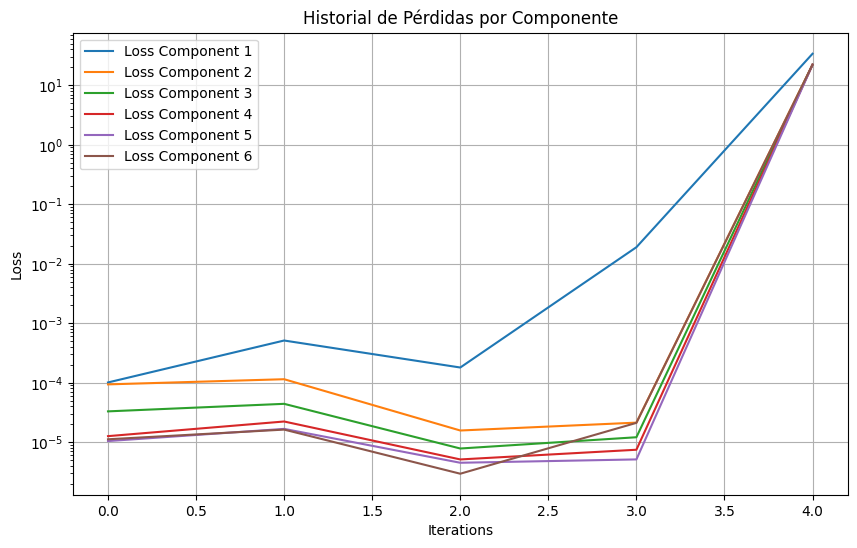

In [ ]:
import matplotlib.pyplot as plt

# history of loss
plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history.loss_train):
    plt.plot(loss, label=f'Loss Component {i+1}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss history by component)
plt.legend()
plt.yscale('log')  # log scle
plt.grid(True)
plt.show()



In [ ]:
#random points in the domain
X_domain = geom.random_points(100)

# Evaluate PDE residuals at the generated points
residuals = model.predict(X_domain, operator=pde)
print("PDE residuals:")
print(residuals)


PDE residuals:
[array([[ 1.76084323e-03],
       [ 1.03667890e-04],
       [ 3.84653672e-04],
       [-2.51477754e-03],
       [-2.14154470e-03],
       [-1.15238243e-03],
       [ 1.20492757e-03],
       [ 3.19873551e-03],
       [-4.12460010e-03],
       [ 2.73683970e-03],
       [-3.60508165e-03],
       [ 1.20643797e-03],
       [ 2.70543846e-04],
       [-1.76382437e-03],
       [ 2.30648826e-03],
       [-3.73428084e-03],
       [-3.87032242e-03],
       [ 2.37424398e-03],
       [ 7.37271184e-04],
       [-4.38675379e-04],
       [-3.44038132e-03],
       [ 2.26581036e-03],
       [-1.96610072e-03],
       [ 9.21406654e-04],
       [-2.34391940e-03],
       [ 1.51103253e-03],
       [-9.04860280e-04],
       [ 1.14340463e-03],
       [ 2.29611432e-03],
       [-1.68120420e-03],
       [ 1.04868221e-03],
       [-4.69186335e-04],
       [ 4.14496987e-03],
       [-5.05926176e-03],
       [-1.54175544e-03],
       [-4.70993540e-04],
       [-3.86242581e-03],
       [-5.96885778e-0

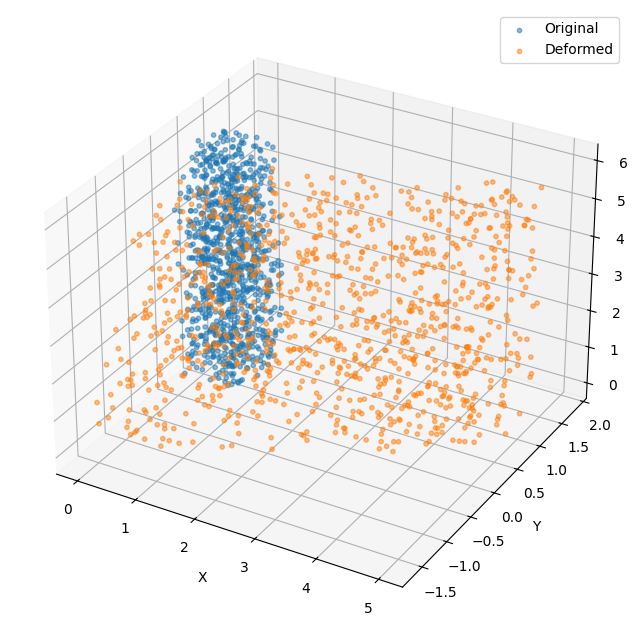

In [ ]:
# Generate points in the domain to evaluate the solution
X = geom.random_points(1000)
u_pred = model.predict(X)

# Visualization of the structure before and after deformation
scaling_factor = 1.0  # Scale factor to visually enhance displacements
X_deformed = X + scaling_factor * u_pred

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], label="Original", alpha=0.5, s=10)  # Points in the original configuration
ax.scatter(X_deformed[:, 0], X_deformed[:, 1], X_deformed[:, 2], label="Deformed", alpha=0.5, s=10)  # Points in the deformed configuration
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.show()


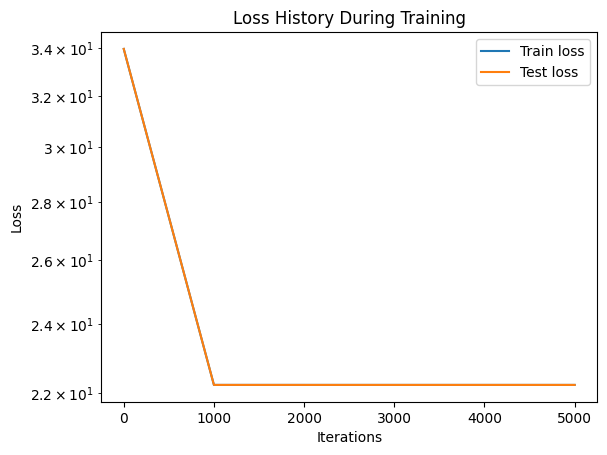

In [ ]:
# Plot the loss history during training
dde.utils.plot_loss_history(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History During Training")
plt.show()



In [ ]:

!pip install plotly

import numpy as np
import plotly.graph_objects as go

# Define the dimensions of the cuboid
L, W, H = 1.0, 1.0, 6.0  # Length, Width, Height

def create_face_grid(face, n1=50, n2=50):
    """
    Create a grid of points on a face of the cuboid.
    'face' is one of:
      'x0', 'xL', 'y0', 'yW', 'z0', 'zH'
    """
    if face == "x0":
        # Face at x = 0, vary y and z.
        y = np.linspace(0, W, n1)
        z = np.linspace(0, H, n2)
        Y, Z = np.meshgrid(y, z)
        X = np.zeros_like(Y)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    elif face == "xL":
        # Face at x = L, vary y and z.
        y = np.linspace(0, W, n1)
        z = np.linspace(0, H, n2)
        Y, Z = np.meshgrid(y, z)
        X = L * np.ones_like(Y)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    elif face == "y0":
        # Face at y = 0, vary x and z.
        x = np.linspace(0, L, n1)
        z = np.linspace(0, H, n2)
        X, Z = np.meshgrid(x, z)
        Y = np.zeros_like(X)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    elif face == "yW":
        # Face at y = W, vary x and z.
        x = np.linspace(0, L, n1)
        z = np.linspace(0, H, n2)
        X, Z = np.meshgrid(x, z)
        Y = W * np.ones_like(X)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    elif face == "z0":
        # Face at z = 0, vary x and y.
        x = np.linspace(0, L, n1)
        y = np.linspace(0, W, n2)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    elif face == "zH":
        # Face at z = H, vary x and y.
        x = np.linspace(0, L, n1)
        y = np.linspace(0, W, n2)
        X, Y = np.meshgrid(x, y)
        Z = H * np.ones_like(X)
        return np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1), (X, Y, Z)
    else:
        raise ValueError("Unknown face.")

# List of faces to visualize
faces = ["x0", "xL", "y0", "yW", "z0", "zH"]
scaling_factor = 1.0  # Adjust as needed

# Initialize lists to hold surface data
surfaces_original = []
surfaces_deformed = []

for face in faces:
    # Create the grid for the current face
    points, (X_orig, Y_orig, Z_orig) = create_face_grid(face, n1=30, n2=30)

    # Predict the displacements on these points
    u_pred = model.predict(points)

    # Ensure u_pred is a flat array with 3 components
    u_pred = u_pred.reshape(-1, 3)

    # Compute deformed positions
    points_deformed = points + scaling_factor * u_pred
    X_def = points_deformed[:, 0].reshape(X_orig.shape)
    Y_def = points_deformed[:, 1].reshape(Y_orig.shape)
    Z_def = points_deformed[:, 2].reshape(Z_orig.shape)

    # Append to lists
    surfaces_original.append((X_orig, Y_orig, Z_orig))
    surfaces_deformed.append((X_def, Y_def, Z_def))

# Initialize Plotly figure
fig = go.Figure()

# Define colors for original and deformed surfaces
orig_color = "lightblue"
def_color = "salmon"

# Add original surfaces
for X_orig, Y_orig, Z_orig in surfaces_original:
    fig.add_trace(go.Surface(
        x=X_orig,
        y=Y_orig,
        z=Z_orig,
        colorscale='Blues',
        opacity=0.5,
        showscale=False,
        name='Original'
    ))

# Add deformed surfaces
for X_def, Y_def, Z_def in surfaces_deformed:
    fig.add_trace(go.Surface(
        x=X_def,
        y=Y_def,
        z=Z_def,
        colorscale='Reds',
        opacity=0.7,
        showscale=False,
        name='Deformed'
    ))

# Update layout for better visualization
fig.update_layout(
    title="Interactive 3D Visualization of Original and Deformed Surfaces",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode='data'  # Ensures equal scaling
    ),
    width=1000,
    height=800,
    showlegend=True,
)

# Add dummy traces for legend
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color=orig_color),
    name='Original',
))
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color=def_color),
    name='Deformed',
))

# Show the interactive plot
fig.show()
